# Zadanie nr 3 - Kompresja tekstu

In [137]:
from treelib import Tree
from heapq import heappush, heappop
from collections import Counter
from bitarray import bitarray, decodetree
from bitarray.util import *
import os
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from time import time

Zadanie polega na implementacji dwóch algorytmów kompresji:

* statycznego algorytmu Huffmana
* dynamicznego algorytmu Huffmana

## 1. Statyczny algorytm Huffmana

In [138]:
class Node:
    def __init__(self, *args, **kwargs):
        self.weight = args[-1]
        self.elements = args[:-1]

    def __str__(self):
        string = ""
        for element in self.elements:
            string += str(element)
        return string

    def __repr__(self):
        return str(self)

    def __lt__(self, other):
        return self.weight < other.weight

In [139]:
def huffman(letter_counts):
    nodes = []
    for a, weight in letter_counts.items():
        nodes.append(Node(a, weight))

    internal_nodes = []
    leafs = sorted(nodes, key=lambda n: n.weight)

    while(len(leafs) + len(internal_nodes) > 1):
        element_1 = get_lowest_weight_node(leafs, internal_nodes)
        element_2 = get_lowest_weight_node(leafs, internal_nodes)

        internal_nodes.append(
            Node(element_1, element_2, element_1.weight + element_2.weight))

    return internal_nodes[0]


def get_lowest_weight_node(leafs, internal):
    if not internal or (leafs and leafs[0].weight < internal[0].weight):
        return leafs.pop(0)
    return internal.pop(0)

In [140]:
def huffman_heap(letter_counts):
    heap = []
    for a, weight in letter_counts.items():
        heappush(heap, Node(a, weight))

    while(len(heap) > 1):
        element_1 = heappop(heap)
        element_2 = heappop(heap)

        heappush(heap, Node(element_1, element_2,
                 element_1.weight + element_2.weight))

    return heappop(heap)

In [141]:
def get_codes(head):
    codes = {}
    head.code = ''

    def walk_tree(node):
        for i, child in enumerate(node.elements):
            child.code = node.code + str(i)

            if len(child.elements) > 1:
                walk_tree(child)
            else:
                codes[child.elements[0]] = bitarray(child.code)

    walk_tree(head)
    return codes

#### wizualizacja drzewa

In [142]:
def show_tree(head):
    tree = Tree()
    tree.create_node(str(head) + ' weight: ' +
                     str(head.weight), head, parent=None)
    head.code = ''

    def create_tree(node):
        for i, child in enumerate(node.elements):
            child.code = node.code + str(i)
            tree.create_node(str(child) + ' weight: ' + str(child.weight) + ' code: ' + str(child.code),
                             child, parent=node)
            if len(child.elements) > 1:
                create_tree(child)

    create_tree(head)
    tree.show()

In [143]:
text = 'abracadabra'
head = huffman(Counter(text))
show_tree(head)

arcdb weight: 11
├── a weight: 5 code: 0
└── rcdb weight: 6 code: 1
    ├── cdb weight: 4 code: 11
    │   ├── b weight: 2 code: 111
    │   └── cd weight: 2 code: 110
    │       ├── c weight: 1 code: 1100
    │       └── d weight: 1 code: 1101
    └── r weight: 2 code: 10



#### kompresja i dekompresja

1. Opracować format pliku przechowującego dane.
2. Zaimplementować algorytm kompresji i dekompresji danych dla tego formatu pliku.

In [144]:
def encode(text, file):
    node = huffman(Counter(text))
    codes = get_codes(node)
    encoded_text = bitarray()
    encoded_text.encode(codes, text)

    mapping = bitarray()

    for letter, code in codes.items():
        letter_utf = bitarray()
        letter_utf.frombytes(letter.encode('utf-32'))
        # print(letter, letter_utf)

        code_len = bitarray()
        code_len.frombytes(len(code).to_bytes(1, 'big'))
        mapping += letter_utf + code_len + code

    letters_count = bitarray()
    letters_count.frombytes(len(codes).to_bytes(4, 'big'))
    text_bit_size = bitarray()
    text_bit_size.frombytes(len(encoded_text).to_bytes(4, 'big'))

    bit_seq = bitarray()
    bit_seq = letters_count + mapping + text_bit_size + encoded_text

    with open(file, 'wb') as f:
        bit_seq.tofile(f)


def decode(file):
    with open(file, 'rb') as f:
        bit_seq = bitarray()
        bit_seq.fromfile(f)

    letters_count = ba2int(bit_seq[:32])
    decode_dict = {}
    i = 32

    for _ in range(letters_count):
        # print(bit_seq[i:i+64])
        letter = bit_seq[i:i+64].tobytes().decode('utf-32')
        # print(letter)
        i += 64
        code_len = ba2int(bit_seq[i:i+8])
        i += 8
        code = bit_seq[i:i+code_len]
        i += code_len

        decode_dict[letter] = code

    text_len = ba2int(bit_seq[i:i+32])
    i += 32

    decode_tree = decodetree(decode_dict)
    text = ''.join(bit_seq[i:i+text_len].decode(decode_tree))
    return text

## 2. Dynamiczny algorytm Huffmana

In [145]:
class AdaptiveNode:
    def __init__(self, char, weight=0, parent=None):
        self.char = char
        self.weight = weight
        self.parent = parent
        self.children = [None, None]
        self.index = -1

    def __str__(self):
        return f'{self.char} {self.weight} {self.code()}'

    def __repr__(self):
        return self.__str__()

    def __lt__(self, other):
        return self.weight < other.weight

    def code(self):
        if self.parent is None:
            return bitarray()
        if self == self.parent.children[0]:
            return self.parent.code() + bitarray('0')
        else:
            return self.parent.code() + bitarray('1')

    def add_child(self, index, child):
        self.children[index] = child
        child.parent = self

    def find_next_at_level(self, level):
        if level == 0:
            return self

        if self.children[0] is not None:
            found = self.children[0].find_next_at_level(level+1)
            if found is not None:
                return found

            found = self.children[1].find_next_at_level(level+1)

            if found is not None:
                return found

        return None

    def right_sibling(self):
        current_node = self
        level = 0

        while current_node.parent is not None:
            if current_node == current_node.parent.children[0]:
                found = current_node.parent.children[1].find_next_at_level(
                    level)
                if found is not None:
                    return found

            current_node = current_node.parent
            level -= 1

        current_node = self
        depth = 0

        while current_node.parent is not None:
            current_node = current_node.parent
            depth += 1

        found = current_node.find_next_at_level(-depth + 1)

        if found is not None:
            return found

        return None

    def increment(self):
        self.weight += 1

        if self.parent:
            right_sib = self.right_sibling()

            if right_sib.weight < self.weight:
                while True:
                    next_sib = right_sib.right_sibling()
                    if next_sib is None or right_sib.weight != next_sib.weight:
                        break
                    else:
                        right_sib = next_sib

                if right_sib != self.parent:
                    swap(self, right_sib)

            self.parent.increment()

def swap(node1, node2):
    node1.parent, node2.parent = node2.parent, node1.parent
    if node1.parent.children[0] == node2:
        node1.parent.children[0] = node1
    else:
        node1.parent.children[1] = node1

    if node2.parent.children[0] == node1:
        node2.parent.children[0] = node2
    else:
        node2.parent.children[1] = node2

In [195]:
def adaptive_huffman(text):
    AdaptiveNode.nodes = []
    nodes = {"#": AdaptiveNode("#", weight=0)}
    head = nodes["#"]

    bits = bitarray()

    for letter in text:
        #show_tree_adaptive(head)
        if letter in nodes:
            node = nodes[letter]
            #print(node.code(), end=' <--')
            # print(node.char)
            bits += node.code()
            #update_tree(node, head)
            node.increment()
        else:
            updated_node = nodes["#"]
            #print("{0:b}".format(ord(letter)) + ' ' + letter)
            letter_bits = bitarray()
            letter_bits.frombytes(letter.encode('utf-32'))
            # print(updated_node.code(), end=' <- ')
            # print(updated_node.char)
            bits += updated_node.code()
            bits += letter_bits
            #print(letter, letter_bits)
            node = AdaptiveNode(letter, parent=updated_node, weight=1)
            nodes[letter] = node
            del nodes["#"]
            zero_node = AdaptiveNode("#", parent=updated_node, weight=0)
            updated_node.add_child(0, zero_node)
            updated_node.add_child(1, node)
            nodes["#"] = zero_node
            #update_tree(updated_node, head)
            updated_node.increment()

    #print(bits)
    return head, bits

#### wizualizacja drzewa

In [147]:
def show_tree_adaptive(head):
    tree = Tree()
    tree.create_node(str(head), head, parent=None)

    def create_tree(node):
        for i, child in enumerate(node.children):
            tree.create_node(str(child),
                             child, parent=node)

            if child and child.children[0] and child.children[1]:
                create_tree(child)

    create_tree(head)
    tree.show()

In [148]:
text = 'abracadabra'
head, bits = adaptive_huffman(text)
show_tree_adaptive(head)

# 11 bitarray()
├── # 6 bitarray('1')
│   ├── # 2 bitarray('10')
│   │   ├── # 1 bitarray('100')
│   │   │   ├── # 0 bitarray('1000')
│   │   │   └── d 1 bitarray('1001')
│   │   └── c 1 bitarray('101')
│   └── # 4 bitarray('11')
│       ├── b 2 bitarray('111')
│       └── r 2 bitarray('110')
└── a 5 bitarray('0')



#### kompresja i dekompresja

In [160]:
def encode_adaptive(text, file):
    head, bits = adaptive_huffman(text)
    
    with open(file, 'wb') as f:
        bits.tofile(f)

In [196]:
def decode_adaptive(file):
    with open(file, 'rb') as f:
        bits = bitarray()
        bits.fromfile(f)
        
    decoded = ""
    nodes = {"#": AdaptiveNode("#", weight=0)}
    head = nodes["#"]
    current_node = head
    index = 0

    while index <= len(bits):
        #show_tree_adaptive(head)

        if current_node.children[0] is None and current_node.children[1] is None:
            if current_node.char != "#":
                decoded += current_node.char
                # print(current_node.char)
                current_node.increment()

            else:
                #print(bits[index:index+8])
                letter = bits[index:index+64].tobytes().decode('utf-32')
                #print(bits[index:index+8], letter)

                index += 64

                decoded += letter
                node = AdaptiveNode(letter, weight=1)
                nodes[letter] = node

                zero_node = AdaptiveNode("#")
                current_node.add_child(0, zero_node)
                current_node.add_child(1, node)
                nodes["#"] = zero_node
                current_node.increment()

            current_node = head

        if index < len(bits):
            current_node = current_node.children[1] if bits[index] == 1 else current_node.children[0]

        index += 1

    return decoded

## 3. Testy

3. Zmierzyć współczynnik kompresji (wyrażone w procentach: 1 - plik_skompresowany / plik_nieskompresowany) dla plików tekstowych o rozmiarach: 1kB, 10kB, 100kB, 1MB, dla różnych typów plików: plik tekstowy z portalu Guttenberga, plik źródłowy z Githubu, plik ze znakami losowanymi z rozkładu jednostajnego.

#### łańcuchy znaków do testów

In [185]:
# normal distribution random
alphabet = list(range(48, 126))
shuffle(alphabet)

with open('text_files/random_normal_full.txt', 'w') as f:
    for _ in range(5000000):
        random_index = round(np.random.normal(len(alphabet)//2, len(alphabet)//5))
        if random_index < 0 or random_index >= len(alphabet):
            continue
        f.write(chr(alphabet[random_index]))
        
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_1MB.txt skip=0 count=11048576  iflag=skip_bytes,count_bytes
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_100kB.txt skip=2048 count=102400  iflag=skip_bytes,count_bytes
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_10kB.txt skip=4096 count=10240  iflag=skip_bytes,count_bytes
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_1kB.txt skip=800 count=1024  iflag=skip_bytes,count_bytes

9674+1 records in
9674+1 records out
4953343 bytes (5,0 MB, 4,7 MiB) copied, 0,0229418 s, 216 MB/s
200+0 records in
200+0 records out
102400 bytes (102 kB, 100 KiB) copied, 0,00115181 s, 88,9 MB/s
20+0 records in
20+0 records out
10240 bytes (10 kB, 10 KiB) copied, 0,000494403 s, 20,7 MB/s
2+0 records in
2+0 records out
1024 bytes (1,0 kB, 1,0 KiB) copied, 0,000372391 s, 2,7 MB/s


In [186]:
sizes = ['1kB', '10kB', '100kB', '1MB']

# powieść z portalu Guttenberg
book_files = [f'text_files/anna_karenina_{size}.txt' for size in sizes]

books = []
for book_file in book_files:
    with open(book_file, 'r') as f:
        books.append(''.join(f).replace('#', '^'))
    
# linux source code
source_code_files = [f'text_files/source_code_{size}.c' for size in sizes]
source_codes = []
for source_file in source_code_files:
    with open(source_file, 'r') as f:
        source_codes.append(''.join(f).replace('#', '^'))
        

# normal distribution random
random_normal_files = [f'text_files/random_normal_{size}.txt' for size in sizes]
random_normals = []
for random_normal in random_normal_files:
    with open(random_normal, 'r') as f:
        random_normals.append(''.join(f).replace('#', '^'))
        
print(Counter(random_normals[0]))
print(random_normal[0])

Counter({'_': 39, 'l': 36, 'C': 34, 'J': 30, 'y': 29, '>': 29, 'D': 29, 'i': 28, 'I': 28, 'g': 27, '?': 27, ':': 25, 'E': 25, '@': 24, 'U': 24, 'Y': 22, '`': 22, '7': 22, '{': 21, '3': 20, 'b': 19, 'd': 19, '1': 19, 'f': 19, 'T': 18, 'q': 18, '}': 18, '<': 18, 'r': 17, 'O': 17, '9': 16, ']': 15, 'j': 15, 'u': 14, 'c': 14, 'n': 14, 'B': 13, '^': 13, 'v': 13, 'A': 12, 'M': 10, 'R': 10, 'x': 9, 's': 9, 'N': 9, 'Z': 9, 'G': 8, 'Q': 8, 'K': 7, 'W': 7, 'S': 7, 'e': 7, 'X': 6, '2': 5, '|': 5, '4': 4, '\\': 4, '5': 4, '8': 3, 'L': 3, '[': 3, 'p': 3, 't': 3, 'o': 3, 'F': 2, '6': 2, 'h': 2, 'k': 2, 'w': 2, 'V': 2, 'a': 2, '=': 1, '0': 1})
t


In [189]:
def get_compression_rate(file, text, static=True):
    file_size = os.path.getsize(file)
    if static:
        encode(text, 'encoded')
    else:
        encode_adaptive(text, 'encoded')
        
    encoded_size = os.path.getsize('encoded')
    return encoded_size/file_size

In [190]:
def plot_compression_rate(rates_static, rates_adaptive, title, sizes):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].set_title(title + ' STATIC')
    ax[0].bar(sizes, rates_static, color='tan')
    
    ax[1].set_title(title + ' ADAPTIVE')
    ax[1].bar(sizes, rates_adaptive, color='sienna')
    
    plt.show()

--text_files/anna_karenina--
STATIC HUFFMAN COMPRESSION
1kB: 97.363281%
10kB: 60.341797%
100kB: 55.174805%
1MB: 54.174805%

ADAPTIVE HUFFMAN COMPRESSION
1kB: 60.058594%
10kB: 55.117188%
100kB: 54.439453%
1MB: 54.100037%


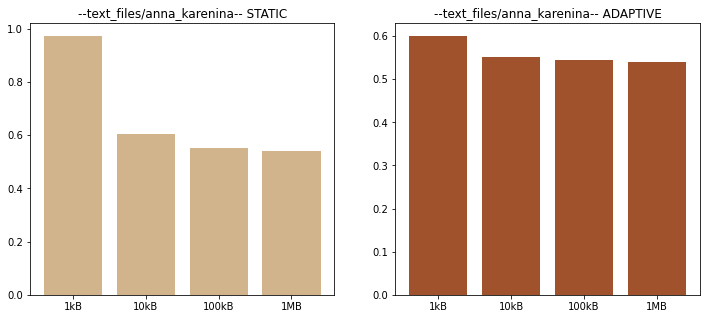


--text_files/source_code--
STATIC HUFFMAN COMPRESSION
1kB: 123.046875%
10kB: 70.175781%
100kB: 64.644531%
1MB: 65.202045%

ADAPTIVE HUFFMAN COMPRESSION
1kB: 69.531250%
10kB: 62.685547%
100kB: 63.846680%
1MB: 65.127087%


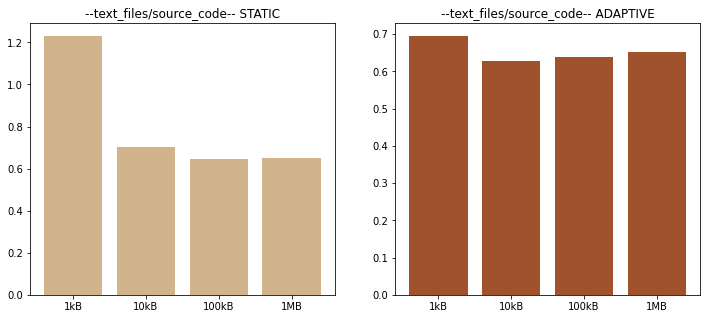


--text_files/random_normal--
STATIC HUFFMAN COMPRESSION
1kB: 143.945312%
10kB: 81.562500%
100kB: 74.875977%
1MB: 74.081868%

ADAPTIVE HUFFMAN COMPRESSION
1kB: 81.640625%
10kB: 75.048828%
100kB: 74.252930%
1MB: 74.081605%


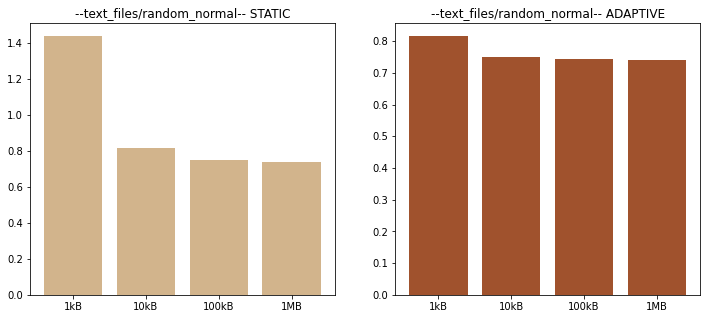

In [191]:
for files, texts in zip([book_files, source_code_files, random_normal_files], [books, source_codes, random_normals]):
    file_type = f'--{"_".join(files[0].split("_")[:3])}--'
    print(file_type)
    
    print('static huffman compression'.upper())
    rates_static = []
    for i, size in enumerate(sizes):
        rates_static.append(get_compression_rate(files[i], texts[i]))
        print(f'{size}: {rates_static[-1]:%}')
    
    print('\nadaptive huffman compression'.upper())
    rates_adaptive = []
    for i, size in enumerate(sizes):
        rates_adaptive.append(get_compression_rate(files[i], texts[i], static=False))
        print(f'{size}: {rates_adaptive[-1]:%}')
    
    
    plot_compression_rate(rates_static, rates_adaptive, file_type, sizes)
    print()

4. Zmierzyć czas kompresji i dekompresji dla plików z punktu 3 dla każdego algorytmu.

In [192]:
def count_time(text, static=True):
    if static:
        encode_start = time()
        encode(text, 'encoded')
        encode_end = time()

        decode_start = time()
        decode('encoded')
        decode_end = time()
    else:
        encode_start = time()
        encode_adaptive(text, 'encoded')
        encode_end = time()

        decode_start = time()
        decode_adaptive('encoded')
        decode_end = time()
    
    return encode_end - encode_start, decode_end - decode_start

In [193]:
def plot_time(static_times, adaptive_times, title, sizes):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].set_title(title)
    ax[0].bar(sizes, static_times[0], color='mediumturquoise')
    ax[0].bar(sizes, static_times[1], bottom=static_times[0], color='aquamarine')
    ax[0].legend(labels=["encoding", "decoding"])
    
    ax[1].set_title(title)
    ax[1].bar(sizes, adaptive_times[0], color='plum')
    ax[1].bar(sizes, adaptive_times[1], bottom=adaptive_times[0], color='slateblue')
    ax[1].legend(labels=["encoding", "decoding"])
    
    plt.show()

--text_files/anna_karenina--
STATIC HUFFMAN COMPRESSION
1kB: encoding: 0.00151 decoding: 0.00024
10kB: encoding: 0.00182 decoding: 0.00074
100kB: encoding: 0.00907 decoding: 0.00408
1MB: encoding: 0.08640 decoding: 0.03776

ADAPTIVE HUFFMAN COMPRESSION
1kB: encoding: 0.00822 decoding: 0.00667
10kB: encoding: 0.06147 decoding: 0.06965
100kB: encoding: 0.56665 decoding: 0.49074
1MB: encoding: 5.65556 decoding: 4.92196


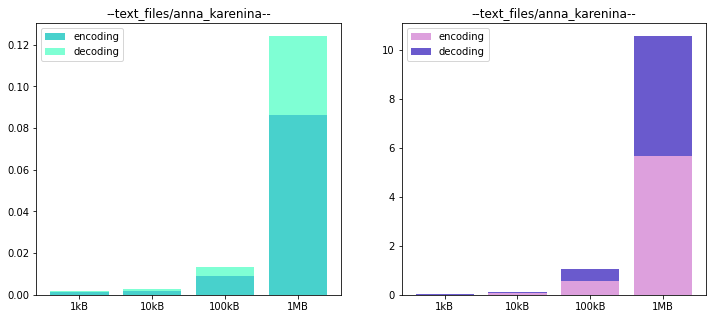


--text_files/source_code--
STATIC HUFFMAN COMPRESSION
1kB: encoding: 0.00145 decoding: 0.00042
10kB: encoding: 0.00352 decoding: 0.00201
100kB: encoding: 0.00931 decoding: 0.00462
1MB: encoding: 0.09208 decoding: 0.04110

ADAPTIVE HUFFMAN COMPRESSION
1kB: encoding: 0.01089 decoding: 0.00967
10kB: encoding: 0.07649 decoding: 0.06623
100kB: encoding: 0.66342 decoding: 0.58215
1MB: encoding: 6.68006 decoding: 5.84625


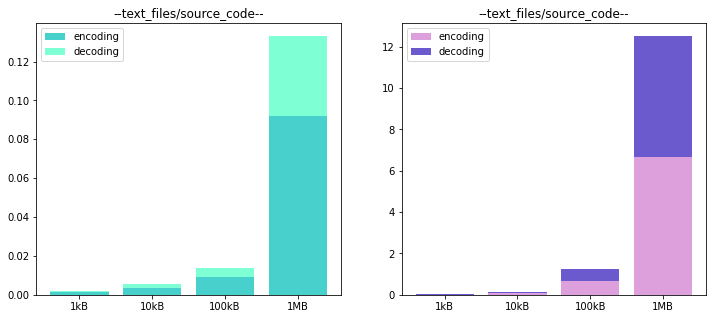


--text_files/random_normal--
STATIC HUFFMAN COMPRESSION
1kB: encoding: 0.00109 decoding: 0.00047
10kB: encoding: 0.00297 decoding: 0.00148
100kB: encoding: 0.01273 decoding: 0.00468
1MB: encoding: 0.44064 decoding: 0.21090

ADAPTIVE HUFFMAN COMPRESSION
1kB: encoding: 0.01415 decoding: 0.01270
10kB: encoding: 0.08794 decoding: 0.07887
100kB: encoding: 0.76065 decoding: 0.66412
1MB: encoding: 35.46407 decoding: 30.89093


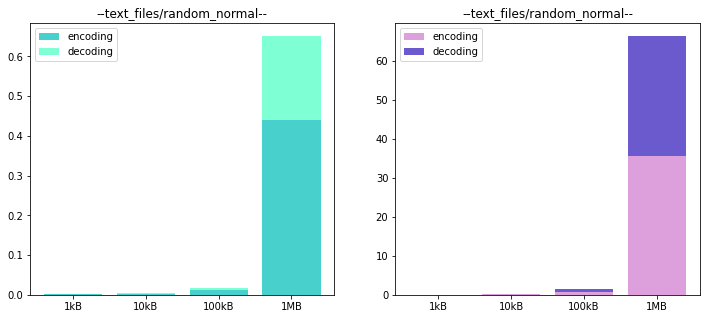

In [199]:
for files, texts in zip([book_files, source_code_files, random_normal_files], [books, source_codes, random_normals]):
    file_type = f'--{"_".join(files[0].split("_")[:3])}--'
    print(file_type)
    
    static_times = [[], []]
    adaptive_times = [[], []]
    
    print('static huffman compression'.upper())
    for i, size in enumerate(sizes):
        encode_time, decode_time = count_time(texts[i])
        static_times[0].append(encode_time)
        static_times[1].append(decode_time)
        
        print(f'{size}: encoding: {encode_time:.5f} decoding: {decode_time:.5f}')
    
    print('\nadaptive huffman compression'.upper())
    for i, size in enumerate(sizes):
        encode_time, decode_time = count_time(texts[i], static=False)
        adaptive_times[0].append(encode_time)
        adaptive_times[1].append(decode_time)
        
        print(f'{size}: encoding: {encode_time:.5f} decoding: {decode_time:.5f}')
    
    plot_time(static_times, adaptive_times, file_type, sizes)
    print()

## 4. Wnioski

- 
- 

M. Hawryluk 23.04.2021